At first we import all the needed libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

After that we import the data and define the the features X and the target value y. 
We need to create a new column "Quality" for the classification. If the Ra value is in the borders the surface is good and if not the surface is bad.
We also split the data in test and train-data for the . After that we split the train data into the final train-data and the validation part.

In [1]:
# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')
index_Ra = dataset.columns.get_loc('Ra')  # Index der Spalte für Rauheit

# Spezifikationsgrenzen
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Einteilung in "gut" und "schlecht"
is_between_specification_bounds = (dataset['Ra'] >= LOWER_SPECIFICATION_LIMIT) & (dataset['Ra'] < UPPER_SPECIFICATION_LIMIT)
good_product_range = np.where(is_between_specification_bounds, "good", "bad")
dataset.insert(index_Ra + 1, 'Quality', good_product_range)

# Features und Zielvariable
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Quality'].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Now data augmentation is used to get more values out of the given data. 

In [ ]:
# Data Augmentation durch Rauschzugabe
noise = np.random.normal(0, 0.01, X_train.shape)  # Rauschen mit Mittelwert 0 und Standardabweichung 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels bleiben gleich

# Verknüpfung von Original- und Augmented Features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

Now the features get scaled because there are some features with very low values and some with very high values. After the scaling the features are in the same range.

In [ ]:
# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Now the raw model is trained with the RandomForestClassifier and the validation and test part are predicted. To analyze the model the accuracy and a report with precision, recall, f1-score and support is printed. 
Additionally the confusion matrix is calculated and plotted for the raw model.

In [ ]:
# Modelltraining mit RandomForestClassifier (Vor Randomized Search)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = classifier.predict(X_test_scaled)
y_val_pred = classifier.predict(X_val_scaled)

# Validation - Evaluierung
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
print(f'Accuracy (Original Model - Validation): {accuracy_val}')
print(f'Classification Report (Original Model - Validation):\n{report_val}\n')

# Evaluierung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy (Original Model): {accuracy}')
print(f'Classification Report (Original Model):\n{report}\n')

# Confusion Matrix für das Originalmodell
cm_original = confusion_matrix(y_test, y_pred)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_original.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_original.flatten()/np.sum(cm_original)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_original, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_original.png', dpi=300)

To optimize the model a hyperparameter tuning is used. The method is the randomized search.
After the best model is found the tuned hyperparameters are printed and the new model is fitted with the train data.

In [ ]:
# Hyperparameter-Raster für Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search für Random Forest Classifier
random_search_classifier = RandomizedSearchCV(estimator=classifier,
                                              param_distributions=param_grid, 
                                              n_iter=100, # Anzahl der zufälligen Kombinationen
                                              cv=5,       # Cross-Validation-Folds
                                              scoring='accuracy', # search for the HP combination with the best accuracy
                                              n_jobs=-1,  # Alle verfügbaren Kerne verwenden
                                              verbose=0,  # Ausführlichkeit
                                              random_state=42)  # Für Reproduzierbarkeit

# Ausgabe der besten Hyperparameter
print(f'Beste Hyperparameter für Classifier: {random_search_classifier.best_params_}\n')

# Fitting the model with the optimized hyperparamaters
random_search_classifier.fit(X_train_scaled, y_train)

# Bestes Modell basierend auf der Suche
best_model = random_search_classifier.best_estimator_

Now the values get predicted with the best model and is also evaluated with the accuracy and a report with precision, recall, f1-score and support. 
The confusion matrix is also calculated and printed for the good model.

In [ ]:
# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)
y_val_pred_best = best_model.predict(X_val_scaled)

# Validation - Evaluierung
accuracy_val_best = accuracy_score(y_val, y_val_pred_best)
report_val_best = classification_report(y_val, y_val_pred_best)
print(f'Accuracy (Original Model - Validation): {accuracy_val_best}')
print(f'Classification Report (Original Model - Validation):\n{report_val_best}\n')

# Evaluierung des besten Modells
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')
print(f'Best Model Classification Report:\n{report_best}\n')

# Confusion Matrix für das optimierte Modell mit y_test
cm_best = confusion_matrix(y_test, y_pred_best)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_best.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_best.flatten()/np.sum(cm_best)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_best, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_best.png', dpi=300)

Another method for possible optimization are the feature importances. They are calculated and are printed in a graph and a list.

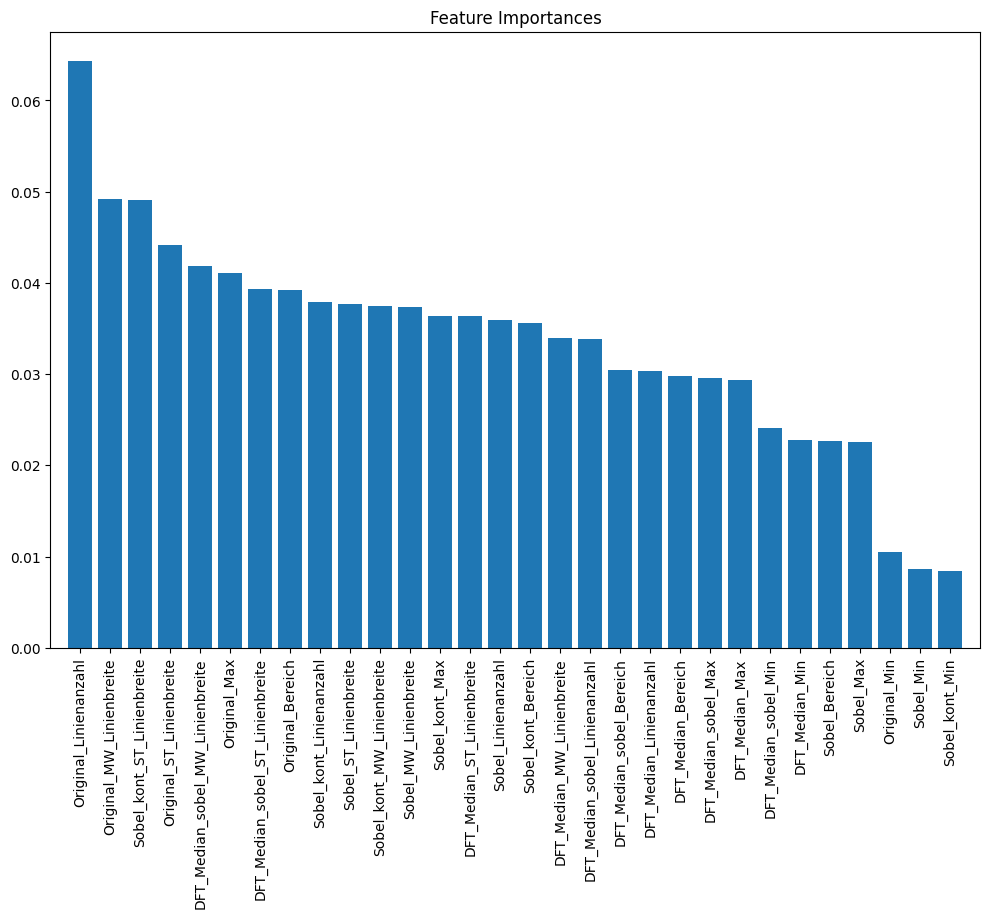

                             Feature  Importance
0              Original_Linienanzahl    0.064314
1           Original_MW_Linienbreite    0.049220
2         Sobel_kont_ST_Linienbreite    0.049071
3           Original_ST_Linienbreite    0.044194
4   DFT_Median_sobel_MW_Linienbreite    0.041862
5                       Original_Max    0.041051
6   DFT_Median_sobel_ST_Linienbreite    0.039291
7                   Original_Bereich    0.039203
8            Sobel_kont_Linienanzahl    0.037937
9              Sobel_ST_Linienbreite    0.037740
10        Sobel_kont_MW_Linienbreite    0.037447
11             Sobel_MW_Linienbreite    0.037370
12                    Sobel_kont_Max    0.036409
13        DFT_Median_ST_Linienbreite    0.036394
14                Sobel_Linienanzahl    0.035909
15                Sobel_kont_Bereich    0.035642
16        DFT_Median_MW_Linienbreite    0.033929
17     DFT_Median_sobel_Linienanzahl    0.033816
18          DFT_Median_sobel_Bereich    0.030426
19           DFT_Med

In [9]:
# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Namen der Features
feature1 = dataset.columns.get_loc('Original_Linienanzahl')
feature2 = dataset.columns.get_loc('DFT_Median_sobel_Bereich')
feature_names = dataset.columns[feature1:feature2+1]

# Visualisierung der Feature Importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Ausgabe der Feature Importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)



In this function a treshold can be chosen and all the features with lower importances are dropped automatically.

In [12]:

def select_relevant_features(threshold):
    # Filtern der Features mit Importance < treshold
    important_features = feature_importances[feature_importances['Importance'] >= threshold]

    # Liste der zu behaltenden Features
    features_to_keep = important_features['Feature'].values

    # Auswahl der entsprechenden Spalten aus dem ursprünglichen DataFrame
    X_important = dataset[features_to_keep]
    return X_important

threshold = 0.02
X_important = select_relevant_features(threshold)

Completely new train-test split, data augmentation, model training and prediction.

In [11]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data Augmentation durch Rauschzugabe
noise = np.random.normal(0, 0.01, X_train.shape)  # Rauschen mit Mittelwert 0 und Standardabweichung 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels bleiben gleich

# Verknüpfung von Original- und Augmented Features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# Modelltraining mit RandomForestRegressor (after dropping features with low importance)
classifier_dropped = RandomForestClassifier(random_state=42)
classifier_dropped.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred_dropped = classifier_dropped.predict(X_test_scaled)
y_val_pred_dropped = classifier_dropped.predict(X_val_scaled)

# Validation - Evaluierung
accuracy_val_dropped = accuracy_score(y_val, y_val_pred_dropped)
report_val_dropped = classification_report(y_val, y_val_pred_dropped)
print(f'\nAccuracy (Original Model - Validation): {accuracy_val_dropped}')
print(f'Classification Report (Original Model - Validation):\n{report_val_dropped}\n')

# Evaluierung
accuracy_dropped = accuracy_score(y_test, y_pred_dropped)
report_dropped = classification_report(y_test, y_pred_dropped)
print(f'Accuracy (Original Model): {accuracy_dropped}')
print(f'Classification Report (Original Model):\n{report_dropped}\n')

# Confusion Matrix für das Originalmodell
cm_dropped = confusion_matrix(y_test, y_pred_dropped)

# Plot of the confusion matrix
plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad","Bad but predicted as Good","Good but predicted as Bad","Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in cm_dropped.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_dropped.flatten()/np.sum(cm_dropped)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_names)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_dropped, annot=labels, xticklabels=['Bad products', 'Good Products'], yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'cm_dropped.png', dpi=300)

array([0.06431389, 0.04922005, 0.0490708 , 0.04419444, 0.04186195,
       0.04105132, 0.03929117, 0.03920293, 0.03793744, 0.03773993,
       0.03744746, 0.03737036, 0.03640903, 0.03639427, 0.0359094 ,
       0.03564217, 0.03392868, 0.03381636, 0.03042552, 0.03038076,
       0.029773  , 0.02960764, 0.02933498, 0.02410819, 0.02282414,
       0.02265957, 0.02257236, 0.01051188, 0.008636  , 0.00836428])